<a href="https://colab.research.google.com/github/ragomez7/food-cv/blob/main/food_cv_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get helper functions
Importing helper functions from github repositrory to do tasks related with data preprocessing, data visualization, and more.

In [1]:
!wget https://raw.githubusercontent.com/ragomez7/food-cv/main/helper_functions.py

--2021-07-05 18:23:57--  https://raw.githubusercontent.com/ragomez7/food-cv/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10294 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.05K  --.-KB/s    in 0s      

2021-07-05 18:23:57 (99.7 MB/s) - ‘helper_functions.py.2’ saved [10294/10294]



In [2]:
!pip install tensorflow==2.4.1

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Loading the Food 101 Dataset from TensorFlow Datasets

In [4]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

### Exploring the data

In [5]:
ds_info.description

"This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels."

In [6]:
ds_info.splits

{'train': <tfds.core.SplitInfo num_examples=75750>,
 'validation': <tfds.core.SplitInfo num_examples=25250>}

In [7]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names
print(f"The number of classes in the dataset is: {num_classes}")

The number of classes in the dataset is: 101


In [9]:
#Printing all the class names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Exploring the training the data

In [10]:
train_one_sample = train_data.take(1)
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 74
  Class name (str form): peking_duck
        


Getting acquainted with all the different image shapes

In [11]:
image_shapes = []
label_values = []
for image, label in train_data.take(30000):
  image_shapes.append(image.shape.as_list())
  label_values.append(label)

In [12]:
unique_shapes = len(np.unique(image_shapes,axis=0))
unique_labels = len(np.unique(label_values))
print(f"""
    Images come in plenty of different shapes, by taking a sample of 30,000 images 
    from the training set, we get a total amount of unique shapes of {unique_shapes}.
    As expected, the number of unique values that labels take are {unique_labels}, ranging
    from {min(label_values)} to {max(label_values)}
    """
    )


    Images come in plenty of different shapes, by taking a sample of 30,000 images 
    from the training set, we get a total amount of unique shapes of 347.
    As expected, the number of unique values that labels take are 101, ranging
    from 0 to 100
    


## Getting acquainted with the image tensor

In [13]:
for image,label in train_one_sample:
  image, label

tf.Tensor(
[[[ 43  89 125]
  [ 52  96 131]
  [ 85 128 162]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 42  88 124]
  [ 53  97 132]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 45  89 124]
  [ 52  96 131]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 ...

 [[ 91  99  86]
  [ 89  97  84]
  [ 88  94  82]
  ...
  [ 37  44  50]
  [ 34  41  47]
  [ 31  38  44]]

 [[ 91  99  86]
  [ 90  98  85]
  [ 88  96  83]
  ...
  [ 38  43  47]
  [ 35  40  44]
  [ 33  38  42]]

 [[ 93 101  88]
  [ 93 101  88]
  [ 89  97  84]
  ...
  [ 37  42  46]
  [ 35  40  44]
  [ 35  40  44]]], shape=(512, 512, 3), dtype=uint8)


(-0.5, 511.5, 511.5, -0.5)

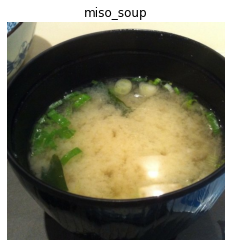

In [14]:
print(image)
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)


### Assessing that the pixel value range is normal

In [15]:
print(f"""
      Range of pixels = ({tf.reduce_min(image)}-{tf.reduce_max(image)})
"""
)


      Range of pixels = (0-255)



> Loaded image tensors are of dtype=uint8. Will need to convert to floats and normalize from 0-1 later on.

## Creating a function to:
* Help visualize images from the training set.
* Confirm the labels are correct.

In [16]:
def plot_9_images(data):
  """
  Plots 9 random images from training dataset.
  """
  images_to_plot = data.take(9)
  image_list = []
  label_list = []
  for image, label in images_to_plot:
    image_list.append(image)
    label_list.append(label)
  plt.figure(figsize=(20,20))
  for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_list[i-1])
    plt.title(class_names[label_list[i-1].numpy()], fontsize = 16)
    plt.axis(False)

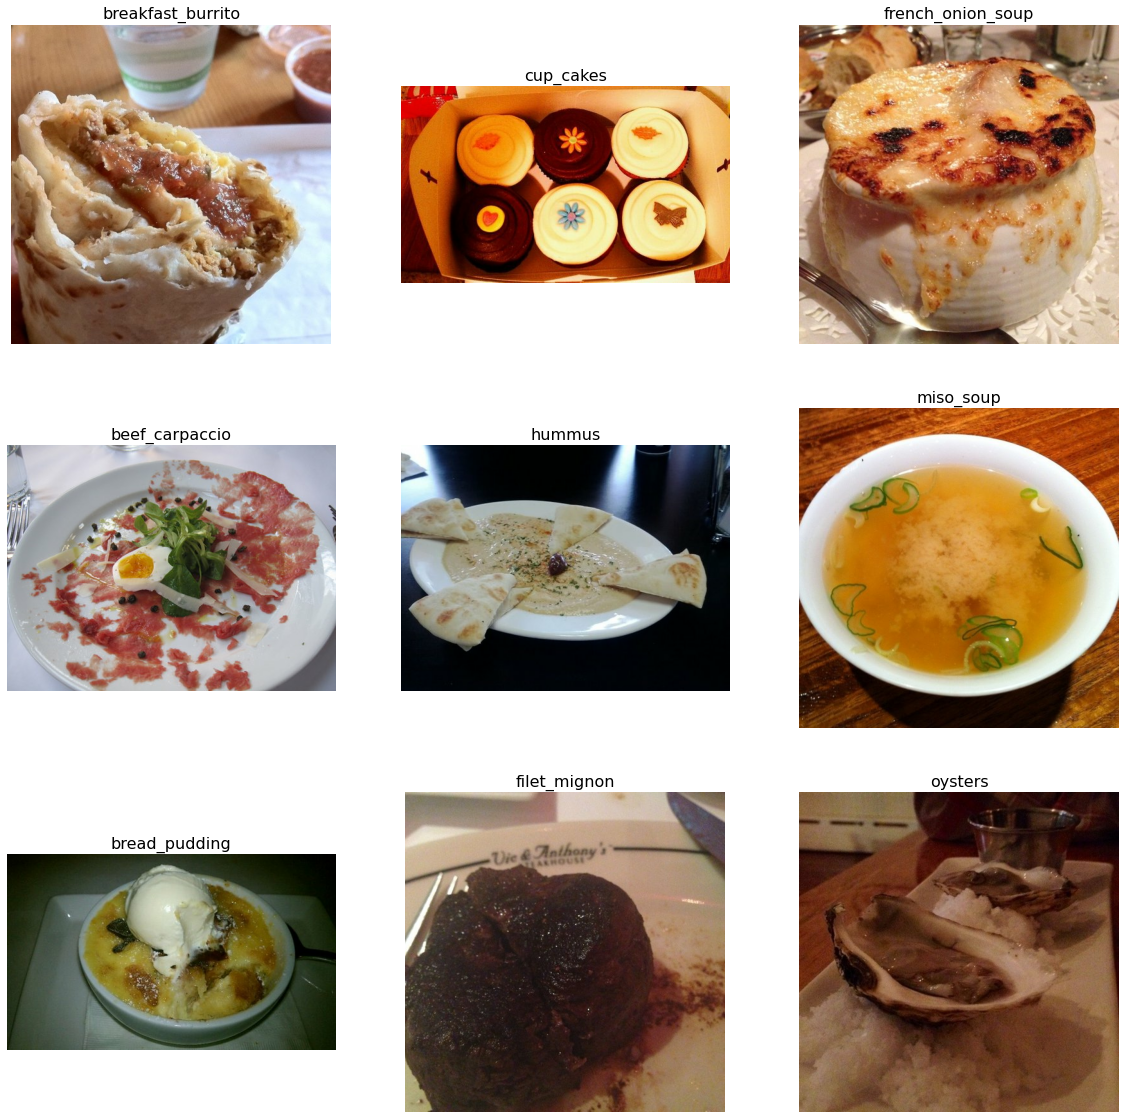

In [17]:
plot_9_images(train_data)

## Creating a preprocessing function
Now that we are initially acquainted with the data, we are going to create a function that preprocesses the image tensors in order for them to be fit for a the neural network architecture we are going to use.

The following function:
* Converts tensor dtype from `uint8` to `float32`
* Reshapes all different image sizes to the same shape. Function default is (224, 224).

We are not going to scale the images from 0-1 because we are initially going to use EfficientNetB0 architecture, which scales tensors by default.
* A good implementation idea is to later add functionality to scale the tensors if needed.

In [18]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  img_shape = img_shape
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple



## Batch & Prepare Datasets
Using the [tf.data API](https://www.tensorflow.org/guide/data) we are going to:


*   Map the preprocess_img function to the entire training and testing set.
*   Reshuffle the datasets
*   Batch datasets with batch_size=32
*   Prefetch and parallelize the process for faster execution



In [19]:
data_shape_before = train_data.element_spec[0].shape #save the training_data shape before processing
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, #apply function to all the instances 
                             num_parallel_calls=tf.data.AUTOTUNE) #parallelizing

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

data_shape_after = train_data.element_spec[0].shape  #save the training_data shape after processing

print(f"""
  Before the transformation, the dataset was comprised of 75,750 elements. The shape of the 
  dataset was {data_shape_before}.
  After the transformation, the dataset is comprised of {len(train_data)} batches of the
  shape {data_shape_after}.
  Batching the dataset will improve compute speed.
"""
)
# Map prepreprocessing function to test data
test_data = test_data.map(map_func=preprocess_img,  #apply function to all the instances 
                          num_parallel_calls=tf.data.AUTOTUNE)  #parallelizing

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)



  Before the transformation, the dataset was comprised of 75,750 elements. The shape of the 
  dataset was (None, None, 3).
  After the transformation, the dataset is comprised of 2368 batches of the
  shape (None, 224, 224, 3).
  Batching the dataset will improve compute speed.



## Creating callbacks
*   To save the model's progress

In [20]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved



In [21]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8e59556e-a602-5fff-0a6d-5f819ab6aafd)


## Enabling Mixed Precision Training
Leverage the power of GPU 16-bit computation to adjust precision when needed to drastically speed up computation.

In [22]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [23]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

## Transfer Learning
### Building a Feature Extraction Model

We're going to use [EfficientNet](https://paperswithcode.com/method/efficientnet), which is an architecture trained on ImageNet that achieved state-of-the-art accuracy on several research datasets, to:
* Build a feature extraction model: Plug in EfficientNet and add an Average Pooling Layer and a Dense layer that adapts to the 101 classes in the dataset.
* Then unfreeze layers and see what happens with our metrics.

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [26]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

In [52]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 47s 60ms/step - loss: 1.0880 - accuracy: 0.7047


[1.0880162715911865, 0.7047128677368164]

In [36]:
#datadir = !pwd
#datadir

['/content/drive/My Drive/Colab_Notebooks']

In [39]:
#import os
#save_path = '/content/drive/My Drive/Colab_Notebooks'
#file_name = "test.txt"
#completeName = os.path.join(save_path, file_name)

#print(completeName)
##f = open(completeName,"w")
#f.write("Testing")
#f.close

/content/drive/My Drive/Colab_Notebooks/test.txt


<function TextIOWrapper.close>

/content


## Saved the Model to Google Drive for future use

In [51]:
# # Create save path to drive 
save_dir = "drive/MyDrive/Food_101/models/efficientnetb0_feature_extraction/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
model.save(save_dir)

tensorflow.python.keras.engine.functional.Functional

In [ ]:
loaded_model = tf.keras.models.load_model(save_dir)

In [59]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________
